In [361]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
import sklearn.tree as tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import neighbors
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import (cross_val_score, GridSearchCV, 
                                     train_test_split, StratifiedShuffleSplit)
from sklearn.model_selection import learning_curve
#import graphviz

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [362]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def _gridSearchCV(estimator, param_grid, X, y, test_size=0.2):
    grid_search = GridSearchCV(
        estimator=estimator(),
        param_grid=param_grid,
        cv=StratifiedShuffleSplit(n_splits=10, test_size=test_size),
        scoring=metrics.make_scorer(metrics.roc_auc_score),
        n_jobs=-1
    )
    grid_search.fit(X, y)
    return grid_search

In [120]:
def calc_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    return train_sizes, train_scores, test_scores

In [121]:
def plot_learning_curve(title, train_sizes, train_scores, test_scores, ylim=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [4]:
#Save the metrics
def getPerfMetrics(gridSearchCVmodel, X, y, model_name, pos_name, neg_name):
    gs = gridSearchCVmodel
    
    gs_res = pd.DataFrame(gs.cv_results_)

    y_pred = gs.predict(X)

    accuracy = metrics.accuracy_score(y, y_pred)
    AUROC = gs.score(X, y)
    confusion_matrix= metrics.confusion_matrix(y, y_pred)
    prfs = metrics.precision_recall_fscore_support(y, y_pred)

    confusion_matrix_frac = confusion_matrix / prfs[3].sum()
    confusion_matrix_frac = pd.DataFrame(confusion_matrix_frac, 
             columns=['pred '+neg_name, 'pred '+pos_name],
            index=['actual '+neg_name, 'actual '+pos_name])

    params = pd.DataFrame(
        gs.best_params_,
        index=[model_name+" best parameters"]
    )
    gen_results = pd.DataFrame(
        {'Accuracy': accuracy,
         'AUROC-score': AUROC
        },
        index=[model_name]
    )
    class_results = pd.DataFrame(
         {'Precision': prfs[0],
         'Recall': prfs[1],
         'F-score': prfs[2],
         'Support': prfs[3]
         },
        index=[pos_name,neg_name]
    )

    return gs.cv_results_, params, gen_results, class_results, confusion_matrix_frac

# Poisonous mushrooms

In [403]:
#df = pd.read_csv('datasets/mushrooms.csv')
df = pd.read_csv('https://raw.githubusercontent.com/sventopia/ML/master/datasets/mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [327]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [330]:
df.columns.tolist()

['class',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'bruises',
 'odor',
 'gill-attachment',
 'gill-spacing',
 'gill-size',
 'gill-color',
 'stalk-shape',
 'stalk-root',
 'stalk-surface-above-ring',
 'stalk-surface-below-ring',
 'stalk-color-above-ring',
 'stalk-color-below-ring',
 'veil-type',
 'veil-color',
 'ring-number',
 'ring-type',
 'spore-print-color',
 'population',
 'habitat']

In [404]:
#remove entries with unknown stalk root
df = df[df['stalk-root'] != '?']

In [365]:
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,5644,5644,5644,5644,5644,5644,5644,5644,5644,5644,...,5644,5644,5644,5644,5644,5644,5644,5644,5644,5644
unique,2,6,4,8,2,7,2,2,2,9,...,4,7,7,1,2,3,4,6,6,6
top,e,x,y,g,t,n,f,c,b,p,...,s,w,w,p,w,o,p,n,v,d
freq,3488,2840,2220,1696,3184,2776,5626,4620,4940,1384,...,3544,3136,3088,5644,5636,5488,3488,1920,2160,2492


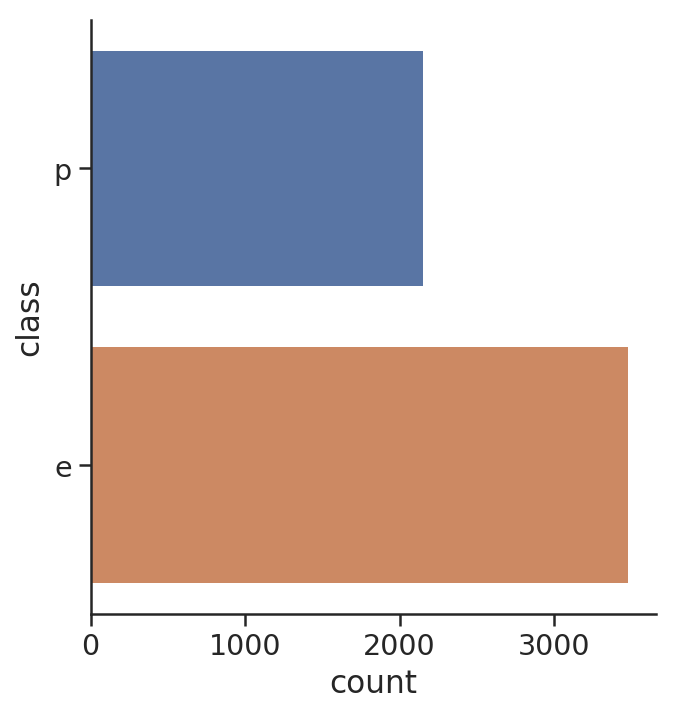

In [334]:
sns.set(font_scale=1.3)
sns.set_style("ticks")
sns.catplot(
    y='class',
    data=df,
    kind='count')

In [405]:
#split off the response variable
y = df['class'].to_frame()
X = df.loc[:, df.columns != 'class']

In [406]:
#encode dummy variables
X_enc = pd.get_dummies(X)

#Scale
scaler = StandardScaler()
X_std = scaler.fit_transform(X_enc)

In [368]:
X_enc.head()

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_n,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u
0,0,0,0,0,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [407]:
#encode the target variable
le = LabelEncoder()
y_enc = le.fit_transform(y.values.ravel())

### Decision trees

In [11]:
param_grid = [{
    'max_depth': list(range(1,10,1)),
    'criterion': ['gini','entropy']
}]

gs_dt_m = _gridSearchCV(
    tree.DecisionTreeClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [124]:
#Calculate learning curve
cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = tree.DecisionTreeClassifier(**gs_dt_m.best_params_)
dt_m_train_sizes, dt_m_train_scores, dt_m_test_scores = calc_learning_curve(
    estimator, title, X_std, y_enc)

In [12]:
#Save the metrics
model_name = 'decision tree'
pos_class = 'poisonous'
neg_class = 'edible'
cv_res_dt_m, params_dt_m, gen_res_dt_m, class_res_dt_m, conf_mat_dt_m = getPerfMetrics(gs_dt_m, X_std, y_enc, model_name, pos_class, neg_class)

In [408]:
#Visualize the tree
clf = tree.DecisionTreeClassifier(**gs_dt_m.best_params_)
clf.fit(X_std, y_enc)
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X_enc.columns,
                                class_names=['e','p'],
                                filled=True, rounded=True,
                                label='root',
                                impurity=False,
                                special_characters=False)  
graph = graphviz.Source(dot_data)  
graph.render('mushroom')

'mushroom.pdf'

In [13]:
params_dt_m

,criterion,max_depth
decision tree best parameters,gini,5


In [14]:
gen_res_dt_m

,Accuracy,AUROC-score
decision tree,1.0,1.0


In [15]:
class_res_dt_m

,Precision,Recall,F-score,Support
poisonous,1.0,1.0,1.0,3488
edible,1.0,1.0,1.0,2156


In [16]:
conf_mat_dt_m

,pred edible,pred poisonous
actual edible,0.618001,0.000000
actual poisonous,0.000000,0.381999


<module 'matplotlib.pyplot' from '/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

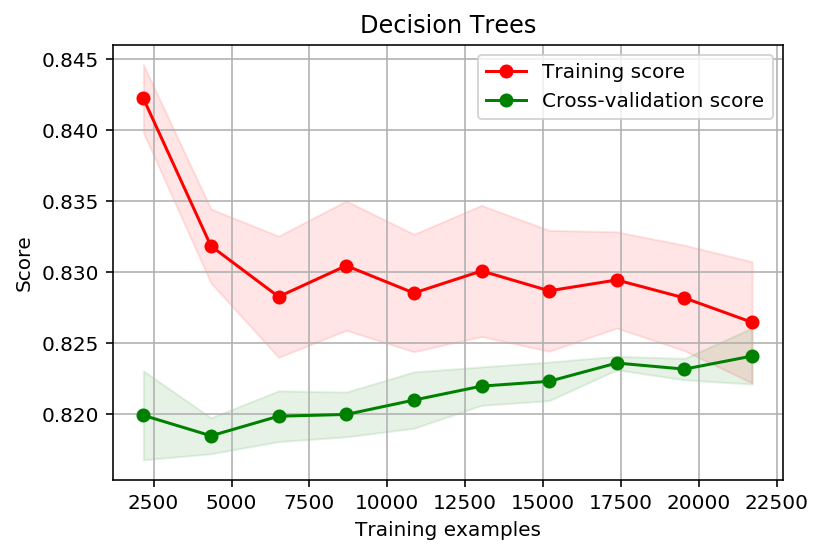

In [123]:
#Print the learning curve
title = "Decision Trees"
plot_learning_curve(title, dt_m_train_sizes, dt_m_train_scores, dt_m_test_scores)

In [114]:
dt_m_lc.show()

In [115]:
dt_m_train_scores

array([0.84106759, 0.83334229, 0.83109803, 0.8296372 , 0.82871622,
       0.82816931, 0.82700159, 0.8267161 , 0.82574969, 0.82559928])

In [116]:
dt_m_test_scores

array([0.8155489 , 0.81977276, 0.82174267, 0.82286965, 0.82276524,
       0.8234362 , 0.82259788, 0.82278366, 0.82247812, 0.8225902 ])

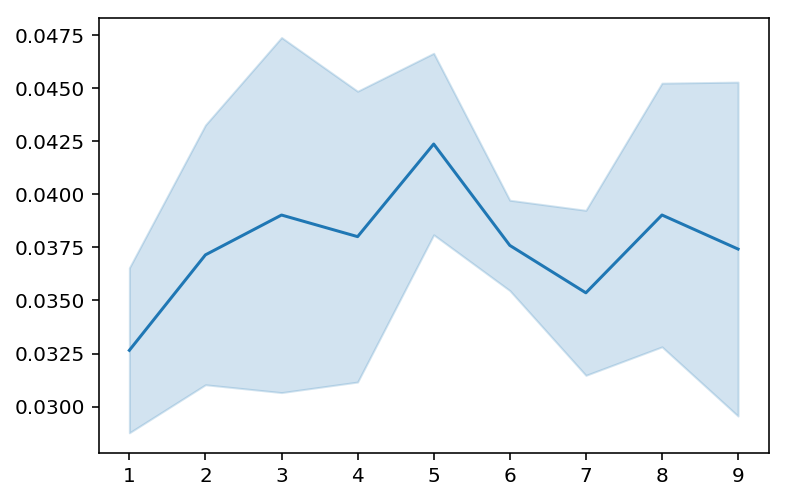

In [18]:
#computational performance
sns.lineplot(
    x='param_max_depth',
    y='mean_fit_time',
    data=cv_res_dt_m)

### AdaBoosting

In [163]:
### Boosting
param_grid = [{
    'n_estimators': list(range(10,100,10)),
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 1.0],
    'algorithm': ['SAMME','SAMME.R']
}]
gs_ada_m = _gridSearchCV(
    AdaBoostClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [164]:
#Calculate the learning curve
cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = AdaBoostClassifier(**gs_ada_m.best_params_)
ada_m_train_sizes, ada_m_train_scores, ada_m_test_scores = calc_learning_curve(
    estimator, title, X_std, y_enc)

In [165]:
#Save the metrics
model_name = 'AdaBoost'
cv_res_ada_m, params_ada_m, gen_res_ada_m, class_res_ada_m, conf_mat_ada_m = getPerfMetrics(gs_ada_m, X_std, y_enc, model_name, pos_class, neg_class)

In [166]:
params_ada_m

,algorithm,learning_rate,n_estimators
AdaBoost best parameters,SAMME,1.0,50


In [167]:
gen_res_ada_m

,Accuracy,AUROC-score
AdaBoost,1.0,1.0


In [168]:
class_res_ada_m

,Precision,Recall,F-score,Support
> $50k,1.0,1.0,1.0,3488
<= $50k,1.0,1.0,1.0,2156


In [169]:
conf_mat_ada_m

,pred <= $50k,pred > $50k
actual <= $50k,0.618001,0.000000
actual > $50k,0.000000,0.381999


<module 'matplotlib.pyplot' from '/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

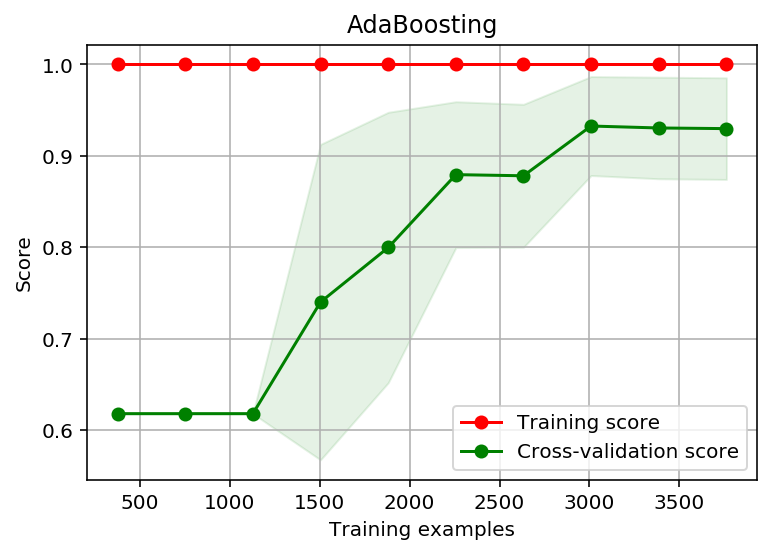

In [170]:
#Print the learning curve
title = "AdaBoosting"
plot_learning_curve(title, ada_m_train_sizes, ada_m_train_scores, ada_m_test_scores)

### Boosting

In [ ]:
### Boosting
param_grid = [{
    'n_estimators': list(range(5,25,1)),
    'max_depth': list(range(1,10,1)),
    'criterion': ['gini','entropy']
}]
gs_rf_m = _gridSearchCV(
    RandomForestClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [125]:
#Calculate the learning curve
cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = RandomForestClassifier(**gs_rf_m.best_params_)
rf_m_train_sizes, rf_m_train_scores, rf_m_test_scores = calc_learning_curve(
    estimator, title, X_std, y_enc)

In [ ]:
#Save the metrics
model_name = 'random forests'
cv_res_rf_m, params_rf_m, gen_res_rf_m, class_res_rf_m, conf_mat_rf_m = getPerfMetrics(gs_rf_m, X_std, y_enc, model_name, pos_class, neg_class)

In [ ]:
params_rf_m

,criterion,max_depth,n_estimators
random forests best parameters,gini,7,15


In [ ]:
gen_res_rf_m

,Accuracy,AUROC-score
random forests,1.0,1.0


In [ ]:
class_res_rf_m

,Precision,Recall,F-score,Support
poisonous,1.0,1.0,1.0,3488
edible,1.0,1.0,1.0,2156


In [ ]:
conf_mat_rf_m

,pred edible,pred poisonous
actual edible,0.618001,0.000000
actual poisonous,0.000000,0.381999


<module 'matplotlib.pyplot' from '/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

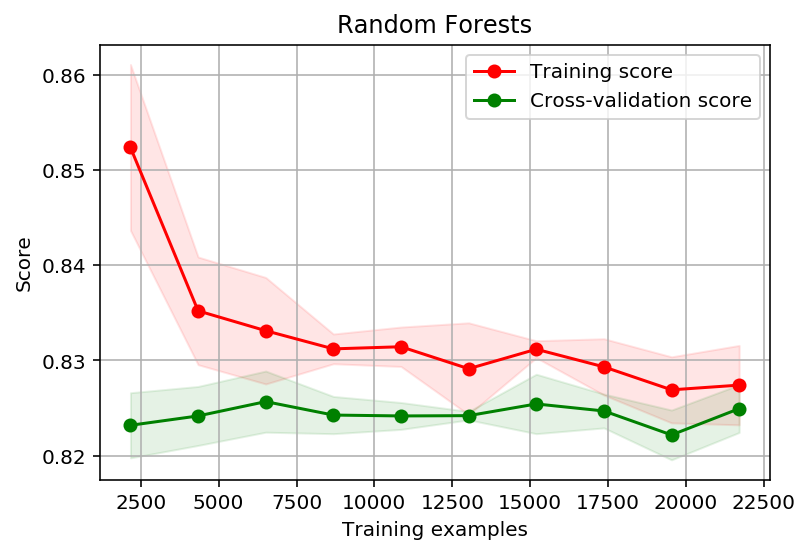

In [126]:
#Print the learning curve
title = "Random Forests"
plot_learning_curve(title, rf_m_train_sizes, rf_m_train_scores, rf_m_test_scores)

### KNN

In [ ]:
param_grid = [{
    'n_neighbors': list(range(1,3,1)),
    'weights': ['uniform','distance'],
    'metric': ['minkowski','manhattan']
}]
gs_knn_m = _gridSearchCV(
    neighbors.KNeighborsClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [127]:
#Calculate the learning curve
cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = neighbors.KNeighborsClassifier(**gs_knn_m.best_params_)
knn_m_train_sizes, knn_m_train_scores, knn_m_test_scores = calc_learning_curve(
    estimator, title, X_std, y_enc)

In [ ]:
#Save the metrics
model_name = 'kNN'
cv_res_knn_m, params_knn_m, gen_res_knn_m, class_res_knn_m, conf_mat_knn_m = getPerfMetrics(gs_knn_m, X_std, y_enc, model_name, pos_class, neg_class)

In [ ]:
params_knn_m

,metric,n_neighbors,weights
kNN best parameters,minkowski,1,uniform


In [ ]:
gen_res_knn_m

,Accuracy,AUROC-score
kNN,1.0,1.0


In [ ]:
class_res_knn_m

,Precision,Recall,F-score,Support
poisonous,1.0,1.0,1.0,3488
edible,1.0,1.0,1.0,2156


In [ ]:
conf_mat_knn_m

,pred edible,pred poisonous
actual edible,0.618001,0.000000
actual poisonous,0.000000,0.381999


<module 'matplotlib.pyplot' from '/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

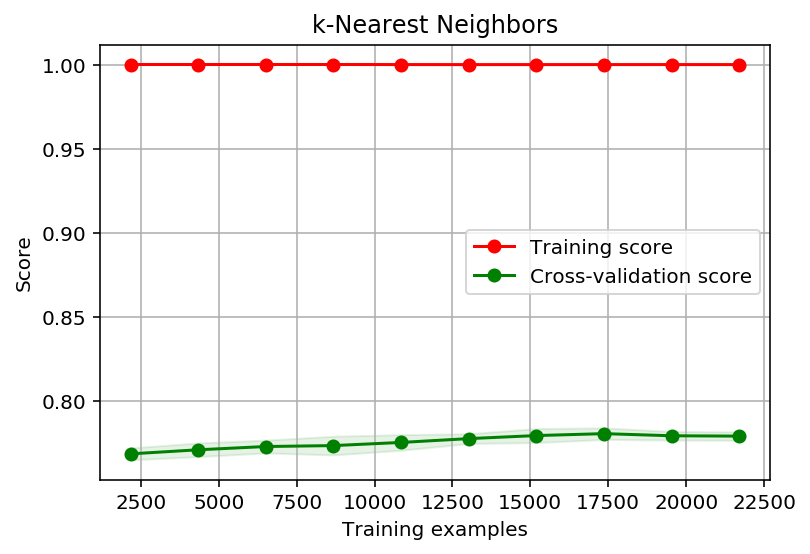

In [134]:
#Print the learning curve
title = "k-Nearest Neighbors"
plot_learning_curve(title, knn_m_train_sizes, knn_m_train_scores, knn_m_test_scores)

### SVM

In [ ]:
param_grid = [{
    'kernel': ['linear','poly','rbf','sigmoid'],
    'degree': list(range(1,4,1)),
    'decision_function_shape': ['ovr','ovo']
}]
gs_svm_m = _gridSearchCV(
    SVC, 
    param_grid,
    X_std, 
    y_enc)

In [128]:
#Calculate the learning curve
cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = SVC(**gs_svm_m.best_params_)
svm_m_train_sizes, svm_m_train_scores, svm_m_test_scores = calc_learning_curve(
    estimator, title, X_std, y_enc)

In [ ]:
#Save the metrics
model_name = 'Support Vector Machines'
cv_res_svm_m, params_svm_m, gen_res_svm_m, class_res_svm_m, conf_mat_svm_m = getPerfMetrics(gs_svm_m, X_std, y_enc, model_name, pos_class, neg_class)

In [ ]:
params_svm_m

,decision_function_shape,degree,kernel
Support Vector Machines best parameters,ovr,1,linear


In [ ]:
gen_res_svm_m

,Accuracy,AUROC-score
Support Vector Machines,1.0,1.0


In [ ]:
class_res_svm_m

,Precision,Recall,F-score,Support
poisonous,1.0,1.0,1.0,3488
edible,1.0,1.0,1.0,2156


In [ ]:
conf_mat_svm_m

,pred edible,pred poisonous
actual edible,0.618001,0.000000
actual poisonous,0.000000,0.381999


<module 'matplotlib.pyplot' from '/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

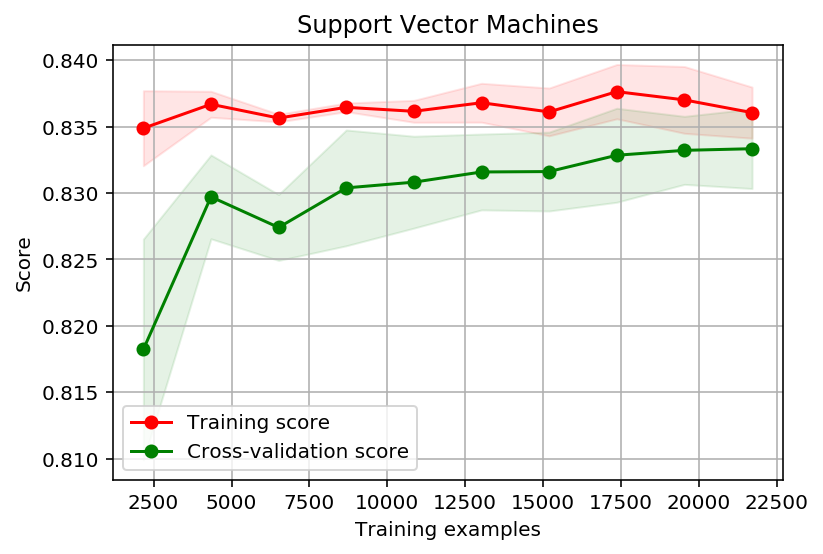

In [133]:
#Print the learning curve
title = "Support Vector Machines"
plot_learning_curve(title, svm_m_train_sizes, svm_m_train_scores, svm_m_test_scores)

### Neural Networks

In [ ]:
param_grid = [{
    'hidden_layer_sizes': [(n,) for n in list(range(1,20,1))],
    'solver': ['lbfgs','sgd','adam'],
    'activation': ['relu','logistic'],
    'learning_rate': ['constant','invscaling']
}]
gs_mlp_m = _gridSearchCV(
    MLPClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [131]:
#Calculate the learning curve
cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = MLPClassifier(**gs_mlp_m.best_params_)
mlp_m_train_sizes, mlp_m_train_scores, mlp_m_test_scores = calc_learning_curve(
    estimator, title, X_std, y_enc)

In [ ]:
#Save the metrics
model_name = 'Neural Network'
cv_res_mlp_m, params_mlp_m, gen_res_mlp_m, class_res_mlp_m, conf_mat_mlp_m = getPerfMetrics(gs_mlp_m, X_std, y_enc, model_name, pos_class, neg_class)

In [ ]:
params_mlp_m

,activation,hidden_layer_sizes,learning_rate,solver
Neural Network best parameters,relu,5,constant,lbfgs


In [ ]:
gen_res_mlp_m

,Accuracy,AUROC-score
Neural Network,1.0,1.0


In [218]:
class_res_mlp_m

,Precision,Recall,F-score,Support
poisonous,1.0,1.0,1.0,3488
edible,1.0,1.0,1.0,2156


In [232]:
conf_mat_mlp_m

,pred edible,pred poisonous
actual edible,0.618001,0.000000
actual poisonous,0.000000,0.381999


<module 'matplotlib.pyplot' from '/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

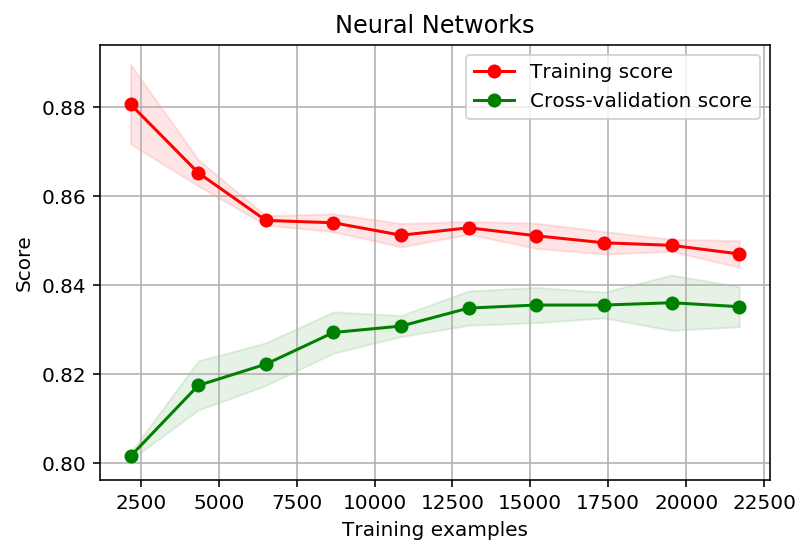

In [132]:
#Print the learning curve
title = "Neural Networks"
plot_learning_curve(title, mlp_m_train_sizes, mlp_m_train_scores, mlp_m_test_scores)

In [277]:
models = ['decision tree', 'adaboost', 'kNN', 'SVM', 'neural net']
mean_fit_time = [cv_res_dt_m['mean_fit_time'][gs_dt_m.best_index_],
                 cv_res_ada_m['mean_fit_time'][gs_ada_m.best_index_],
                 cv_res_knn_m['mean_fit_time'][gs_knn_m.best_index_],
                 cv_res_svm_m['mean_fit_time'][gs_svm_m.best_index_],
                 cv_res_mlp_m['mean_fit_time'][gs_mlp_m.best_index_]]

mean_train_score = [cv_res_dt_m['mean_train_score'][gs_dt_m.best_index_],
                    cv_res_ada_m['mean_train_score'][gs_ada_m.best_index_],
                    cv_res_knn_m['mean_train_score'][gs_knn_m.best_index_],
                    cv_res_svm_m['mean_train_score'][gs_svm_m.best_index_],
                    cv_res_mlp_m['mean_train_score'][gs_mlp_m.best_index_]]

accuracy = [gen_res_dt_m['Accuracy'][0],
            gen_res_ada_m['Accuracy'][0],
            gen_res_knn_m['Accuracy'][0],
            gen_res_svm_m['Accuracy'][0],
            gen_res_mlp_m['Accuracy'][0]]

AUROC = [gen_res_dt_m['AUROC-score'][0],
         gen_res_ada_m['AUROC-score'][0],
         gen_res_knn_m['AUROC-score'][0],
         gen_res_svm_m['AUROC-score'][0],
         gen_res_mlp_m['AUROC-score'][0]]

precision_poisonous = [class_res_dt_m['Precision'][0],
                       class_res_ada_m['Precision'][0],
                       class_res_knn_m['Precision'][0],
                       class_res_svm_m['Precision'][0],
                       class_res_mlp_m['Precision'][0]]

precision_edible = [class_res_dt_m['Precision'][1],
                    class_res_ada_m['Precision'][1],
                    class_res_knn_m['Precision'][1],
                    class_res_svm_m['Precision'][1],
                    class_res_mlp_m['Precision'][1]]

recall_poisonous = [class_res_dt_m['Recall'][0],
                       class_res_ada_m['Recall'][0],
                       class_res_knn_m['Recall'][0],
                       class_res_svm_m['Recall'][0],
                       class_res_mlp_m['Recall'][0]]
recall_edible = [class_res_dt_m['Recall'][1],
                       class_res_ada_m['Recall'][1],
                       class_res_knn_m['Recall'][1],
                       class_res_svm_m['Recall'][1],
                       class_res_mlp_m['Recall'][1]]
Fscore_poisonous = [class_res_dt_m['F-score'][0],
                       class_res_ada_m['F-score'][0],
                       class_res_knn_m['F-score'][0],
                       class_res_svm_m['F-score'][0],
                       class_res_mlp_m['F-score'][0]]
Fscore_edible = [class_res_dt_m['F-score'][1],
                       class_res_ada_m['F-score'][1],
                       class_res_knn_m['F-score'][1],
                       class_res_svm_m['F-score'][1],
                       class_res_mlp_m['F-score'][1]]
pred_actual_edible = [conf_mat_dt_m.iloc[0,0],
                      conf_mat_ada_m.iloc[0,0],
                      conf_mat_knn_m.iloc[0,0],
                      conf_mat_svm_m.iloc[0,0],
                      conf_mat_mlp_m.iloc[0,0]]
pred_false_edible = [conf_mat_dt_m.iloc[0,1],
                      conf_mat_ada_m.iloc[0,1],
                      conf_mat_knn_m.iloc[0,1],
                      conf_mat_svm_m.iloc[0,1],
                      conf_mat_mlp_m.iloc[0,1]]
actual_false_poisonous = [conf_mat_dt_m.iloc[1,0],
                      conf_mat_ada_m.iloc[1,0],
                      conf_mat_knn_m.iloc[1,0],
                      conf_mat_svm_m.iloc[1,0],
                      conf_mat_mlp_m.iloc[1,0]]
actual_pred_poisonous = [conf_mat_dt_m.iloc[1,1],
                      conf_mat_ada_m.iloc[1,1],
                      conf_mat_knn_m.iloc[1,1],
                      conf_mat_svm_m.iloc[1,1],
                      conf_mat_mlp_m.iloc[1,1]]

x_model_res_m = pd.DataFrame(
    [models,
     mean_fit_time,
     mean_train_score,
     accuracy,
     AUROC,
     precision_poisonous,
     precision_edible,
     recall_poisonous,
     recall_edible,
     Fscore_poisonous,
     Fscore_edible,
     pred_actual_edible,
     pred_false_edible,
     actual_false_poisonous,
     actual_pred_poisonous
    ],
    columns=['decision tree','adaboost','kNN','SVM','neural net'],
    index=['model',
        'mean_fit_time',
           'mean_train_score',
           'Accuracy',
           'AUROC score',
          'Precision poisonous',
          'Precision edible',
          'Recall poisonous',
          'Recall edible',
          'F-score poisonous',
          'F-score edible',
          'Predicted actual edible',
          'Predicted false edible',
          'Predicted false poisonous',
          'Predicted actual poisonous']
)
x_model_res_m = x_model_res_m.transpose()
x_model_res_m

,model,mean_fit_time,mean_train_score,Accuracy,AUROC score,Precision poisonous,Precision edible,Recall poisonous,Recall edible,F-score poisonous,F-score edible,Predicted actual edible,Predicted false edible,Predicted false poisonous,Predicted actual poisonous
decision tree,decision tree,0.0466365,1,1,1,1,1,1,1,1,1,0.618001,0,0,0.381999
adaboost,adaboost,0.607151,1,1,1,1,1,1,1,1,1,0.618001,0,0,0.381999
kNN,kNN,0.092171,1,1,1,1,1,1,1,1,1,0.618001,0,0,0.381999
SVM,SVM,0.195601,1,1,1,1,1,1,1,1,1,0.618001,0,0,0.381999
neural net,neural net,0.10252,1,1,1,1,1,1,1,1,1,0.618001,0,0,0.381999


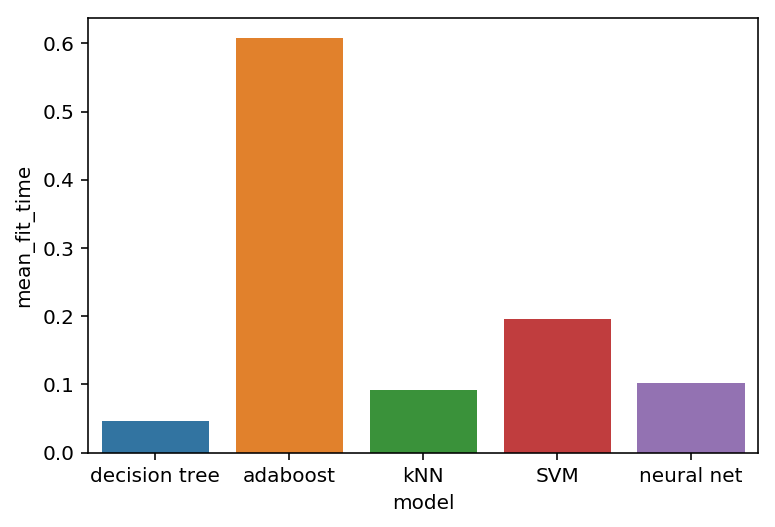

In [278]:
sns.barplot(y='mean_fit_time',x='model',data=x_model_res_m)

In [352]:
x_model_res_m.columns

Index(['model', 'mean_fit_time', 'mean_train_score', 'Accuracy', 'AUROC score',
       'Precision poisonous', 'Precision edible', 'Recall poisonous',
       'Recall edible', 'F-score poisonous', 'F-score edible',
       'Predicted actual edible', 'Predicted false edible',
       'Predicted false poisonous', 'Predicted actual poisonous'],
      dtype='object')

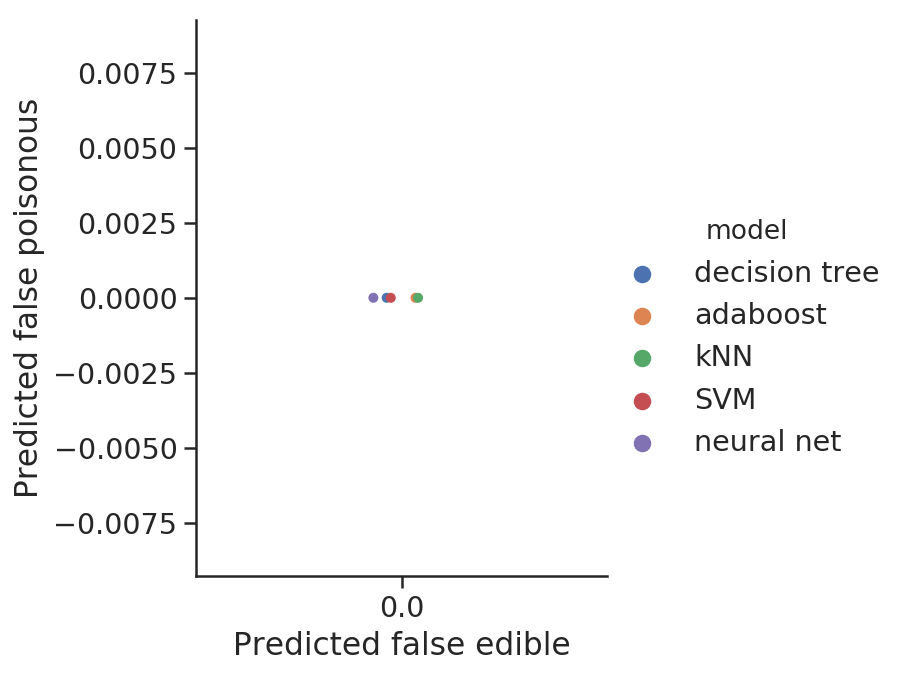

In [353]:
#Show the confusion matrices per model
xm = x_model_res_m.loc[:, ['model','Predicted false edible', 'Predicted false poisonous']]
sns.catplot(x='Predicted false edible',y='Predicted false poisonous',hue='model',data=xm)

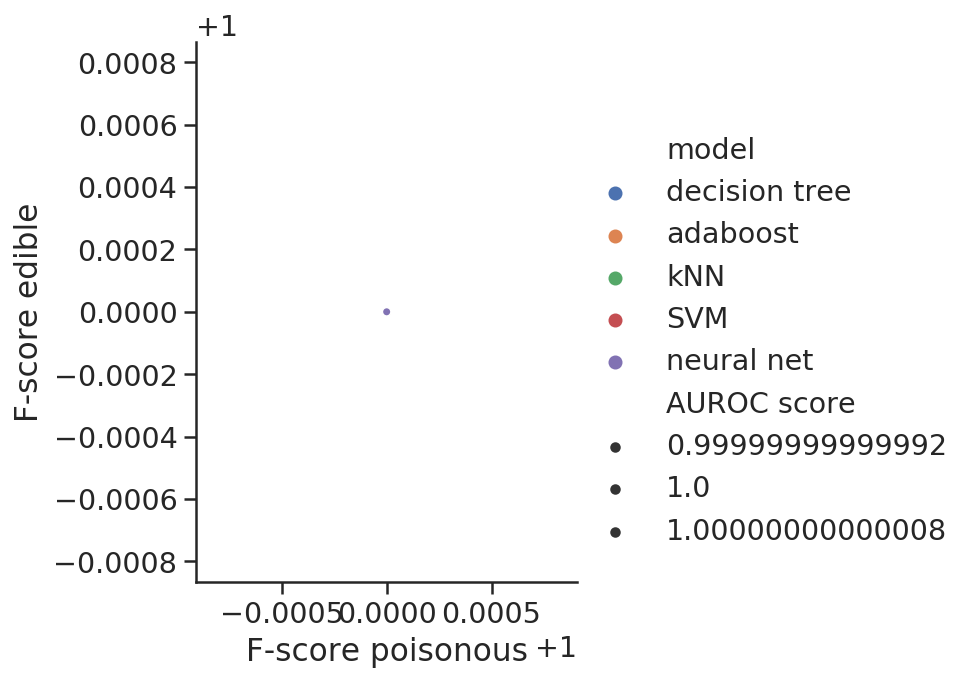

In [355]:
sns.relplot(x='F-score poisonous',
            y='F-score edible', 
            hue='model',
            size='AUROC score',
            data=x_model_res_m)

# Adult dataset

In [390]:
#df = pd.read_csv('datasets/adult/adult.data.txt', header=None)
df = pd.read_csv('https://raw.githubusercontent.com/sventopia/ML/master/datasets/adult/adult.data.txt', header=None)
df.columns = ['age','workclass','fnlwgt','education','education-num','marital-status',
                  'occupation','relationship','race','sex','capital-gain','capital-loss',
                  'hours-per-week','native-country','income']
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [391]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


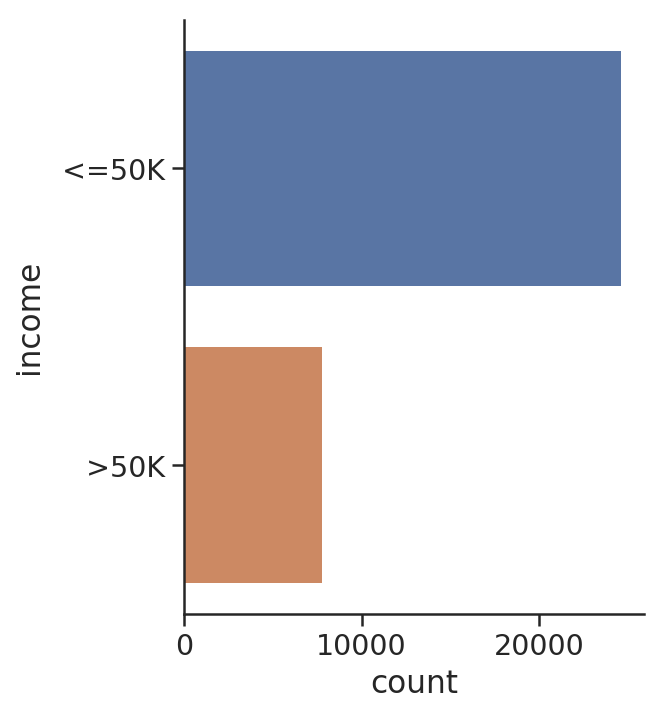

In [343]:
sns.set(font_scale=1.3)
sns.set_style("ticks")
sns.catplot(
    y='income',
    data=df,
    kind='count')

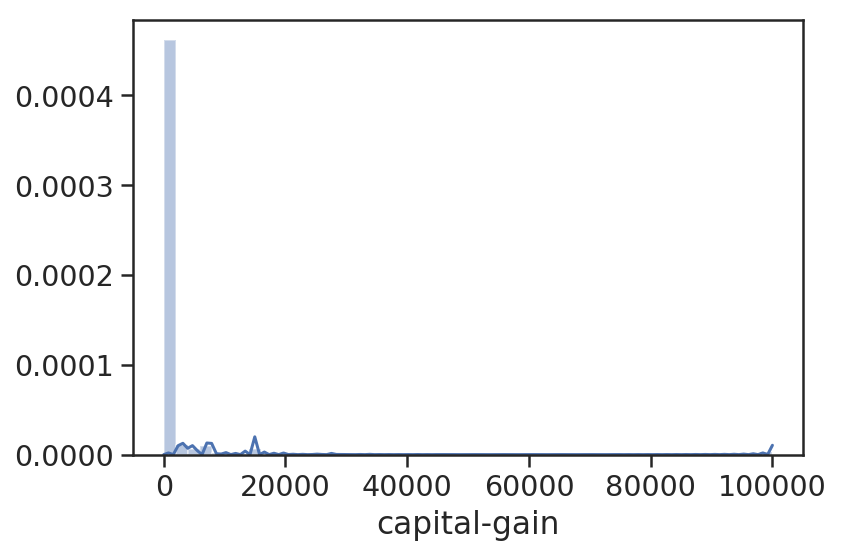

In [345]:
sns.distplot(df['capital-gain'])

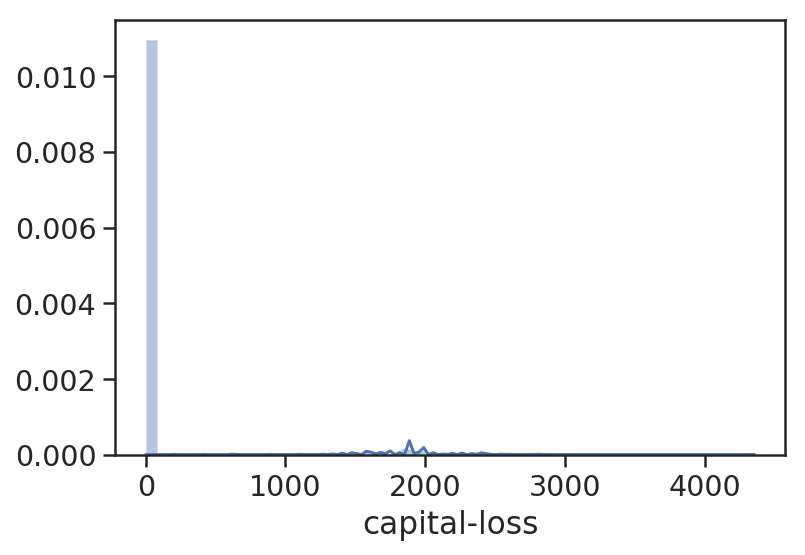

In [346]:
sns.distplot(df['capital-loss'])

In [392]:
df = df.drop(['capital-gain','capital-loss'], axis=1)
#split off the response variable
y = df['income'].to_frame()
X = df.loc[:, df.columns != 'income']

In [393]:
#encode the target variable
le = LabelEncoder()
y_enc = le.fit_transform(y.values.ravel())

#encode dummy variables
X_enc = pd.get_dummies(X)

scaler = StandardScaler()
X_std = scaler.fit_transform(X_enc)

### Decision Trees

In [79]:
param_grid = [{
    'max_depth': list(range(1,10,1)),
    'criterion': ['gini','entropy']
}]
gs_dt_a = _gridSearchCV(
    tree.DecisionTreeClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [135]:
#Calculate learning curve
cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = tree.DecisionTreeClassifier(**gs_dt_a.best_params_)
dt_a_train_sizes, dt_a_train_scores, dt_a_test_scores = calc_learning_curve(
    estimator, title, X_std, y_enc)

In [80]:
#Save the metrics
model_name = 'decision tree'
pos_class = '> $50k'
neg_class = '<= $50k'
cv_res_dt_a, params_dt_a, gen_res_dt_a, class_res_dt_a, conf_mat_dt_a = getPerfMetrics(gs_dt_a, X_std, y_enc, model_name, pos_class, neg_class)

In [402]:
#Visualize the tree
clf = tree.DecisionTreeClassifier(**gs_dt_a.best_params_)
clf.fit(X_std, y_enc)
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=X_enc.columns,
                                class_names=['<=50k','>50k'],
                                filled=True, rounded=True,
                                label='root',
                                impurity=False,
                                special_characters=False)  
graph = graphviz.Source(dot_data)  
graph.render("adult")  

'adult.pdf'

In [81]:
params_dt_a

,criterion,max_depth
decision tree best parameters,entropy,9


In [82]:
gen_res_dt_a

,Accuracy,AUROC-score
decision tree,0.845889,0.768926


In [83]:
class_res_dt_a

,Precision,Recall,F-score,Support
> $50k,0.883995,0.917395,0.900385,24720
<= $50k,0.704358,0.620457,0.659750,7841


In [84]:
conf_mat_dt_a

,pred <= $50k,pred > $50k
actual <= $50k,0.696477,0.062713
actual > $50k,0.091398,0.149412


<module 'matplotlib.pyplot' from '/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

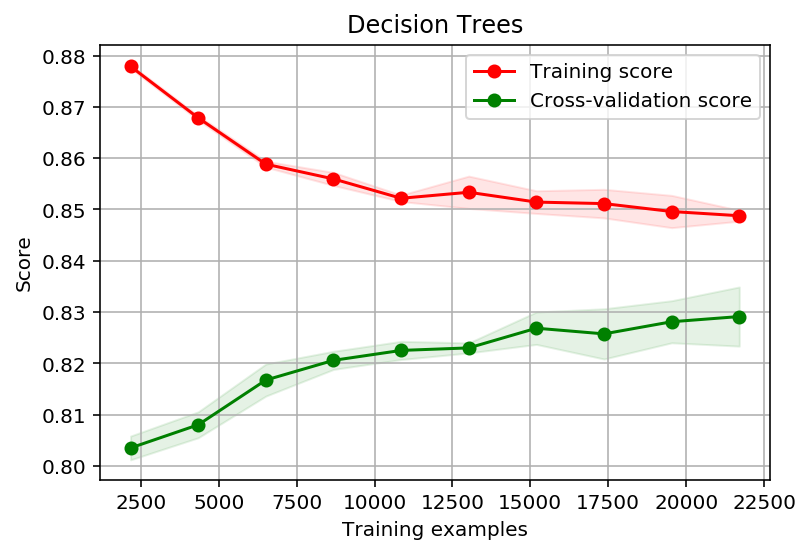

In [136]:
#Print the learning curve
title = "Decision Trees"
plot_learning_curve(title, dt_a_train_sizes, dt_a_train_scores, dt_a_test_scores)

### AdaBoosting

In [174]:
### Boosting
param_grid = [{
    'n_estimators': list(range(10,100,10)),
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 1.0],
    'algorithm': ['SAMME','SAMME.R']
}]
gs_ada_a = _gridSearchCV(
    AdaBoostClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [175]:
#Calculate the learning curve
cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = AdaBoostClassifier(**gs_ada_a.best_params_)
ada_a_train_sizes, ada_a_train_scores, ada_a_test_scores = calc_learning_curve(
    estimator, title, X_std, y_enc)

In [176]:
#Save the metrics
model_name = 'AdaBoost'
cv_res_ada_a, params_ada_a, gen_res_ada_a, class_res_ada_a, conf_mat_ada_a = getPerfMetrics(gs_ada_a, X_std, y_enc, model_name, pos_class, neg_class)

In [178]:
params_ada_a

,algorithm,learning_rate,n_estimators
AdaBoost best parameters,SAMME.R,1.0,90


In [180]:
gen_res_ada_a

,Accuracy,AUROC-score
AdaBoost,0.840023,0.750607


In [409]:
class_res_dt_a

,Precision,Recall,F-score,Support
> $50k,0.883995,0.917395,0.900385,24720
<= $50k,0.704358,0.620457,0.659750,7841


In [182]:
conf_mat_ada_a

,pred <= $50k,pred > $50k
actual <= $50k,0.700808,0.058383
actual > $50k,0.101594,0.139216


<module 'matplotlib.pyplot' from '/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

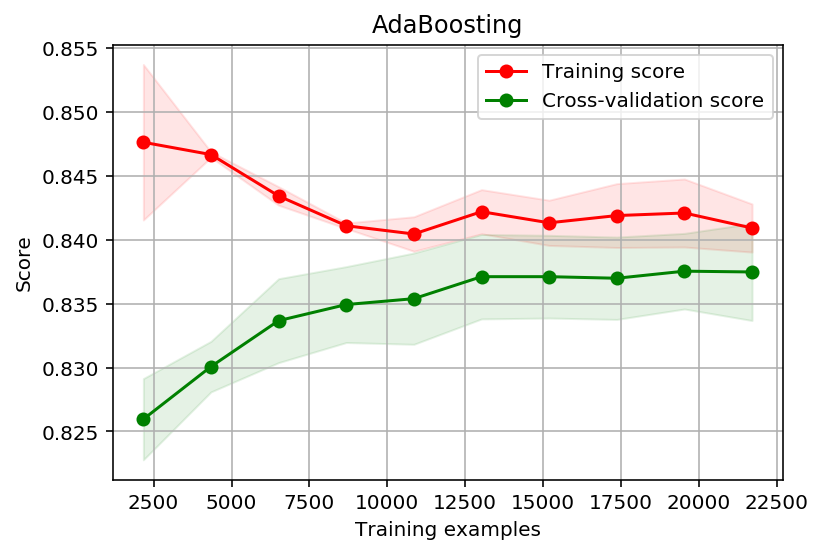

In [183]:
#Print the learning curve
title = "AdaBoosting"
plot_learning_curve(title, ada_a_train_sizes, ada_a_train_scores, ada_a_test_scores)

### Boosting

In [ ]:
### Boosting
param_grid = [{
    'n_estimators': list(range(5,25,1)),
    'max_depth': list(range(1,10,1)),
    'criterion': ['gini','entropy']
}]
gs_rf_a = _gridSearchCV(
    RandomForestClassifier, 
    param_grid,
    X_std,
    y_enc)

In [137]:
#Calculate the learning curve
cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = RandomForestClassifier(**gs_rf_a.best_params_)
rf_a_train_sizes, rf_a_train_scores, rf_a_test_scores = calc_learning_curve(
    estimator, title, X_std, y_enc)

In [ ]:
#Save the metrics
model_name = 'random forests'
cv_res_rf_a, params_rf_a, gen_res_rf_a, class_res_rf_a, conf_mat_rf_a = getPerfMetrics(gs_rf_a, X_std, y_enc, model_name, pos_class, neg_class)



In [85]:
params_rf_a

,criterion,max_depth,n_estimators
random forests best parameters,gini,9,17


In [86]:
gen_res_rf_a

,Accuracy,AUROC-score
random forests,0.836737,0.717442


In [87]:
class_res_rf_a

,Precision,Recall,F-score,Support
> $50k,0.853520,0.947573,0.898091,24720
<= $50k,0.746727,0.487310,0.589752,7841


In [88]:
conf_mat_rf_a

,pred <= $50k,pred > $50k
actual <= $50k,0.719388,0.039802
actual > $50k,0.123461,0.117349


<module 'matplotlib.pyplot' from '/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

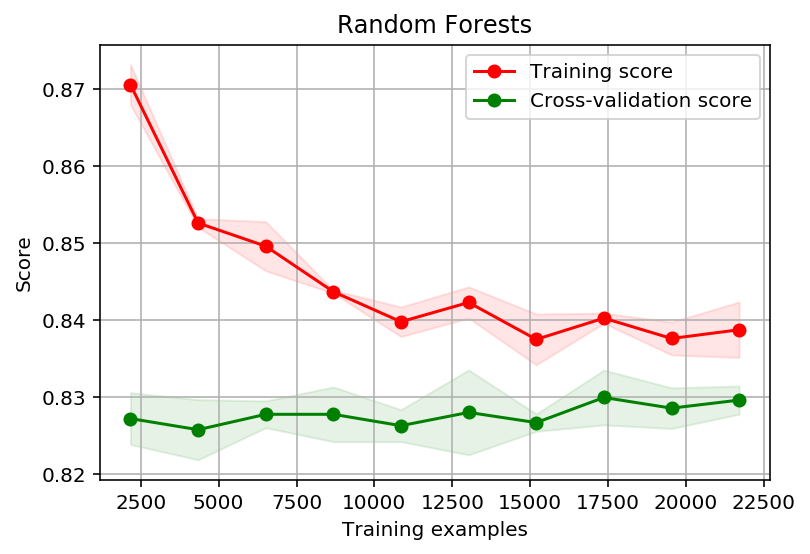

In [138]:
#Print the learning curve
title = "Random Forests"
plot_learning_curve(title, rf_a_train_sizes, rf_a_train_scores, rf_a_test_scores)

### K-nearest neighbors

In [ ]:
param_grid = [{
    'n_neighbors': list(range(1,3,1)),
    'weights': ['uniform','distance'],
    'metric': ['minkowski','manhattan']
}]
gs_knn_a = _gridSearchCV(
    neighbors.KNeighborsClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [139]:
#Calculate the learning curve
cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = neighbors.KNeighborsClassifier(**gs_knn_a.best_params_)
knn_a_train_sizes, knn_a_train_scores, knn_a_test_scores = calc_learning_curve(
    estimator, title, X_std, y_enc)

In [ ]:
#Save the metrics
model_name = 'kNN'
cv_res_knn_a, params_knn_a, gen_res_knn_a, class_res_knn_a, conf_mat_knn_a = getPerfMetrics(gs_knn_a, X_std, y_enc, model_name, pos_class, neg_class)


In [89]:
params_knn_a

,metric,n_neighbors,weights
kNN best parameters,manhattan,1,uniform


In [90]:
gen_res_knn_a

,Accuracy,AUROC-score
kNN,0.999939,0.999872


In [91]:
class_res_knn_a

,Precision,Recall,F-score,Support
> $50k,0.999919,1.000000,0.999960,24720
<= $50k,1.000000,0.999745,0.999872,7841


In [92]:
conf_mat_knn_a

,pred <= $50k,pred > $50k
actual <= $50k,0.759190,0.000000
actual > $50k,0.000061,0.240748


<module 'matplotlib.pyplot' from '/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

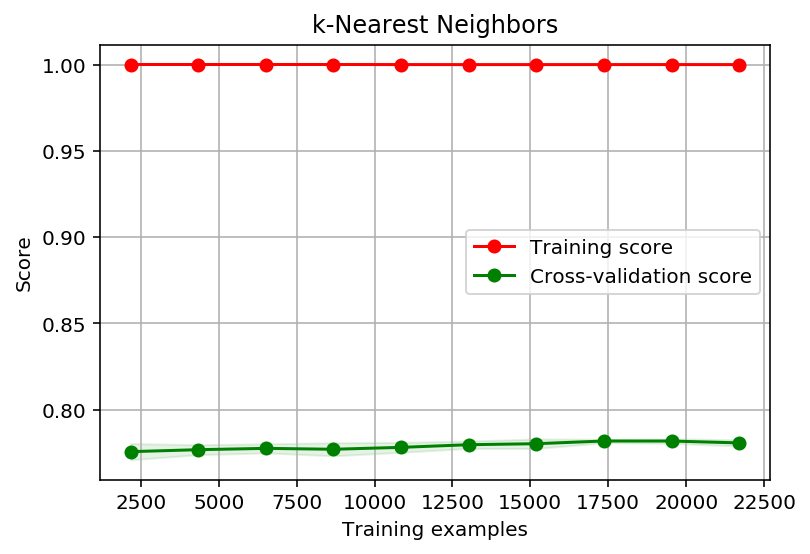

In [140]:
#Print the learning curve
title = "k-Nearest Neighbors"
plot_learning_curve(title, knn_a_train_sizes, knn_a_train_scores, knn_a_test_scores)

### SVM

In [ ]:
param_grid = [{
    'kernel': ['linear','poly','rbf','sigmoid'],
    'degree': list(range(1,4,1)),
    'decision_function_shape': ['ovr','ovo']
}]
gs_svm_a = _gridSearchCV(
    SVC, 
    param_grid,
    X_std, 
    y_enc)

In [141]:
#Calculate the learning curve
cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = SVC(**gs_svm_a.best_params_)
svm_a_train_sizes, svm_a_train_scores, svm_a_test_scores = calc_learning_curve(
    estimator, title, X_std, y_enc)

In [ ]:
#Save the metrics
model_name = 'Support Vector Machines'
cv_res_svm_a, params_svm_a, gen_res_svm_a, class_res_svm_a, conf_mat_svm_a = getPerfMetrics(gs_svm_a, X_std, y_enc, model_name, pos_class, neg_class)

In [93]:
params_svm_a

,decision_function_shape,degree,kernel
Support Vector Machines best parameters,ovr,1,linear


In [94]:
gen_res_svm_a

,Accuracy,AUROC-score
Support Vector Machines,0.836184,0.738848


In [95]:
class_res_svm_a

,Precision,Recall,F-score,Support
> $50k,0.866798,0.926618,0.895710,24720
<= $50k,0.704319,0.551078,0.618346,7841


In [96]:
conf_mat_svm_a

,pred <= $50k,pred > $50k
actual <= $50k,0.703480,0.055711
actual > $50k,0.108105,0.132705


<module 'matplotlib.pyplot' from '/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

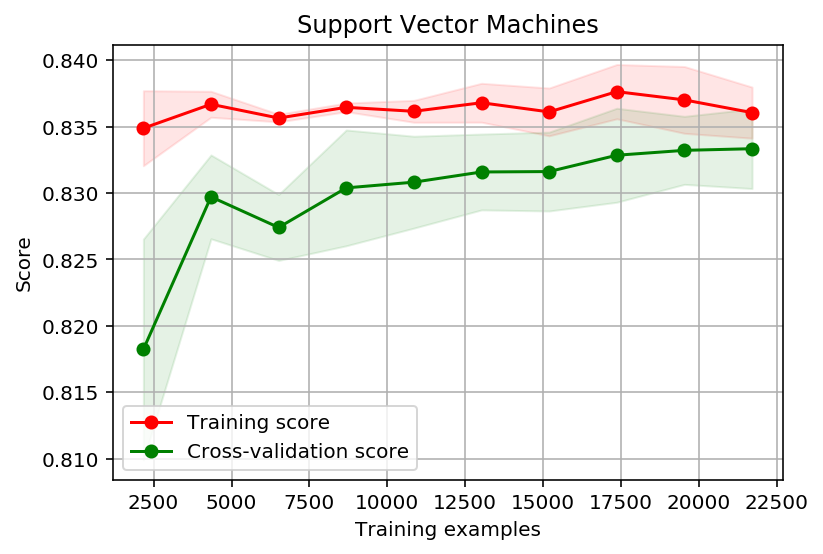

In [142]:
#Print the learning curve
title = "Support Vector Machines"
plot_learning_curve(title, svm_a_train_sizes, svm_a_train_scores, svm_a_test_scores)

### Neural Networks

In [ ]:
param_grid = [{
    'hidden_layer_sizes': [(n,) for n in list(range(1,20,1))],
    'solver': ['lbfgs','sgd','adam'],
    'activation': ['relu','logistic'],
    'learning_rate': ['constant','invscaling']
}]
gs_mlp_a = _gridSearchCV(
    MLPClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [143]:
#Calculate the learning curve
cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = MLPClassifier(**gs_mlp_a.best_params_)
mlp_a_train_sizes, mlp_a_train_scores, mlp_a_test_scores = calc_learning_curve(
    estimator, title, X_std, y_enc)

In [ ]:
#Save the metrics
model_name = 'Neural Network'
cv_res_mlp_a, params_mlp_a, gen_res_mlp_a, class_res_mlp_a, conf_mat_mlp_a = getPerfMetrics(gs_mlp_a, X_std, y_enc, model_name, pos_class, neg_class)


In [97]:
params_mlp_a

,activation,hidden_layer_sizes,learning_rate,solver
Neural Network best parameters,logistic,1,constant,sgd


In [98]:
gen_res_mlp_a

,Accuracy,AUROC-score
Neural Network,0.834649,0.765485


In [99]:
class_res_mlp_a

,Precision,Recall,F-score,Support
> $50k,0.885087,0.898908,0.891944,24720
<= $50k,0.664789,0.632062,0.648013,7841


In [100]:
conf_mat_mlp_a

,pred <= $50k,pred > $50k
actual <= $50k,0.682442,0.076748
actual > $50k,0.088603,0.152207


<module 'matplotlib.pyplot' from '/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

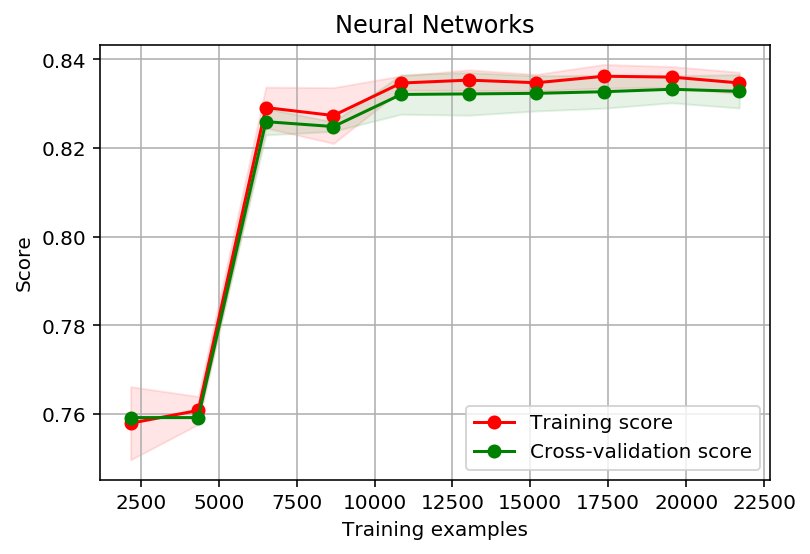

In [144]:
#Print the learning curve
title = "Neural Networks"
plot_learning_curve(title, mlp_a_train_sizes, mlp_a_train_scores, mlp_a_test_scores)

In [301]:
models = ['decision tree', 'adaboost', 'kNN', 'SVM', 'neural net']
mean_fit_time = [cv_res_dt_a['mean_fit_time'][gs_dt_a.best_index_],
                 cv_res_ada_a['mean_fit_time'][gs_ada_a.best_index_],
                 cv_res_knn_a['mean_fit_time'][gs_knn_a.best_index_],
                 cv_res_svm_a['mean_fit_time'][gs_svm_a.best_index_],
                 cv_res_mlp_a['mean_fit_time'][gs_mlp_a.best_index_]]

mean_train_score = [cv_res_dt_a['mean_train_score'][gs_dt_a.best_index_],
                    cv_res_ada_a['mean_train_score'][gs_ada_a.best_index_],
                    cv_res_knn_a['mean_train_score'][gs_knn_a.best_index_],
                    cv_res_svm_a['mean_train_score'][gs_svm_a.best_index_],
                    cv_res_mlp_a['mean_train_score'][gs_mlp_a.best_index_]]

accuracy = [gen_res_dt_a['Accuracy'][0],
            gen_res_ada_a['Accuracy'][0],
            gen_res_knn_a['Accuracy'][0],
            gen_res_svm_a['Accuracy'][0],
            gen_res_mlp_a['Accuracy'][0]]

AUROC = [gen_res_dt_a['AUROC-score'][0],
         gen_res_ada_a['AUROC-score'][0],
         gen_res_knn_a['AUROC-score'][0],
         gen_res_svm_a['AUROC-score'][0],
         gen_res_mlp_a['AUROC-score'][0]]

precision_poisonous = [class_res_dt_a['Precision'][0],
                       class_res_ada_a['Precision'][0],
                       class_res_knn_a['Precision'][0],
                       class_res_svm_a['Precision'][0],
                       class_res_mlp_a['Precision'][0]]

precision_edible = [class_res_dt_a['Precision'][1],
                    class_res_ada_a['Precision'][1],
                    class_res_knn_a['Precision'][1],
                    class_res_svm_a['Precision'][1],
                    class_res_mlp_a['Precision'][1]]

recall_poisonous = [class_res_dt_a['Recall'][0],
                       class_res_ada_a['Recall'][0],
                       class_res_knn_a['Recall'][0],
                       class_res_svm_a['Recall'][0],
                       class_res_mlp_a['Recall'][0]]
recall_edible = [class_res_dt_a['Recall'][1],
                       class_res_ada_a['Recall'][1],
                       class_res_knn_a['Recall'][1],
                       class_res_svm_a['Recall'][1],
                       class_res_mlp_a['Recall'][1]]
Fscore_poisonous = [class_res_dt_a['F-score'][0],
                       class_res_ada_a['F-score'][0],
                       class_res_knn_a['F-score'][0],
                       class_res_svm_a['F-score'][0],
                       class_res_mlp_a['F-score'][0]]
Fscore_edible = [class_res_dt_a['F-score'][1],
                       class_res_ada_a['F-score'][1],
                       class_res_knn_a['F-score'][1],
                       class_res_svm_a['F-score'][1],
                       class_res_mlp_a['F-score'][1]]
pred_actual_edible = [conf_mat_dt_a.iloc[0,0],
                      conf_mat_ada_a.iloc[0,0],
                      conf_mat_knn_a.iloc[0,0],
                      conf_mat_svm_a.iloc[0,0],
                      conf_mat_mlp_a.iloc[0,0]]
pred_false_edible = [conf_mat_dt_a.iloc[0,1],
                      conf_mat_ada_a.iloc[0,1],
                      conf_mat_knn_a.iloc[0,1],
                      conf_mat_svm_a.iloc[0,1],
                      conf_mat_mlp_a.iloc[0,1]]
actual_false_poisonous = [conf_mat_dt_a.iloc[1,0],
                      conf_mat_ada_a.iloc[1,0],
                      conf_mat_knn_a.iloc[1,0],
                      conf_mat_svm_a.iloc[1,0],
                      conf_mat_mlp_a.iloc[1,0]]
actual_pred_poisonous = [conf_mat_dt_a.iloc[1,1],
                      conf_mat_ada_a.iloc[1,1],
                      conf_mat_knn_a.iloc[1,1],
                      conf_mat_svm_a.iloc[1,1],
                      conf_mat_mlp_a.iloc[1,1]]

x_model_res_a = pd.DataFrame(
    [models,
     mean_fit_time,
     mean_train_score,
     accuracy,
     AUROC,
     precision_poisonous,
     precision_edible,
     recall_poisonous,
     recall_edible,
     Fscore_poisonous,
     Fscore_edible,
     pred_actual_edible,
     pred_false_edible,
     actual_false_poisonous,
     actual_pred_poisonous
    ],

    index=['model',
            'mean_fit_time',
           'mean_train_score',
           'Accuracy',
           'AUROC score',
          'Precision > $50k',
          'Precision <= $50k',
          'Recall > $50k',
          'Recall <= $50k',
          'F-score > $50k',
          'F-score <= $50k',
          'Predicted actual <= $50k',
          'Predicted false <= $50k',
          'Predicted false > $50k',
          'Predicted actual > $50k']
)
x_model_res_a = x_model_res_a.transpose()


In [309]:
x_model_res_a.columns

Index(['model', 'mean_fit_time', 'mean_train_score', 'Accuracy', 'AUROC score',
       'Precision > $50k', 'Precision <= $50k', 'Recall > $50k',
       'Recall <= $50k', 'F-score > $50k', 'F-score <= $50k',
       'Predicted actual <= $50k', 'Predicted false <= $50k',
       'Predicted false > $50k', 'Predicted actual > $50k'],
      dtype='object')

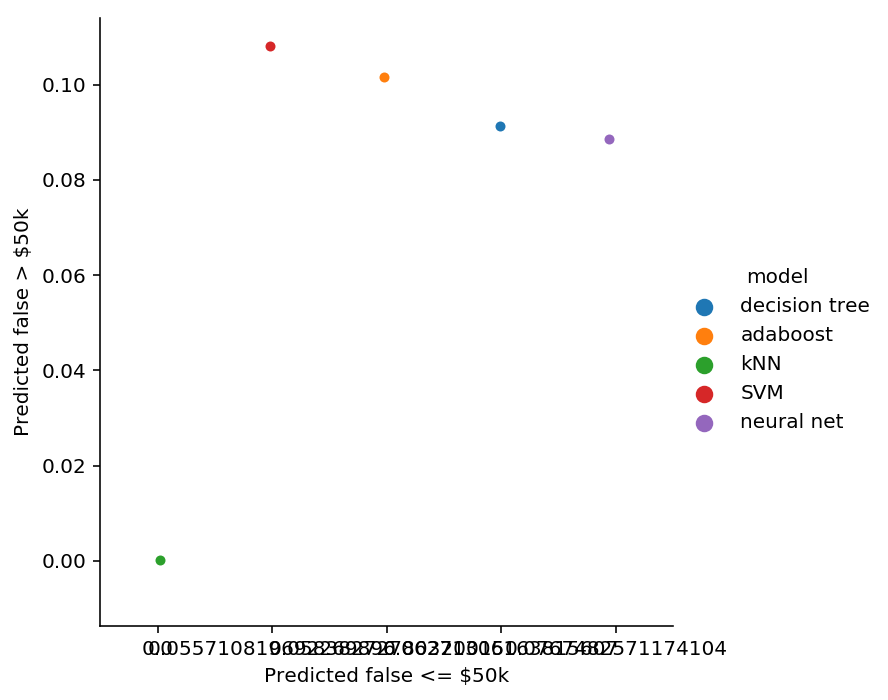

In [323]:
#Show the confusion matrices per model
xm = x_model_res_a.loc[:, ['model','Predicted actual <= $50k', 'Predicted false <= $50k',
       'Predicted false > $50k', 'Predicted actual > $50k']]
sns.catplot(x='Predicted false <= $50k',y='Predicted false > $50k',hue='model',data=xm)

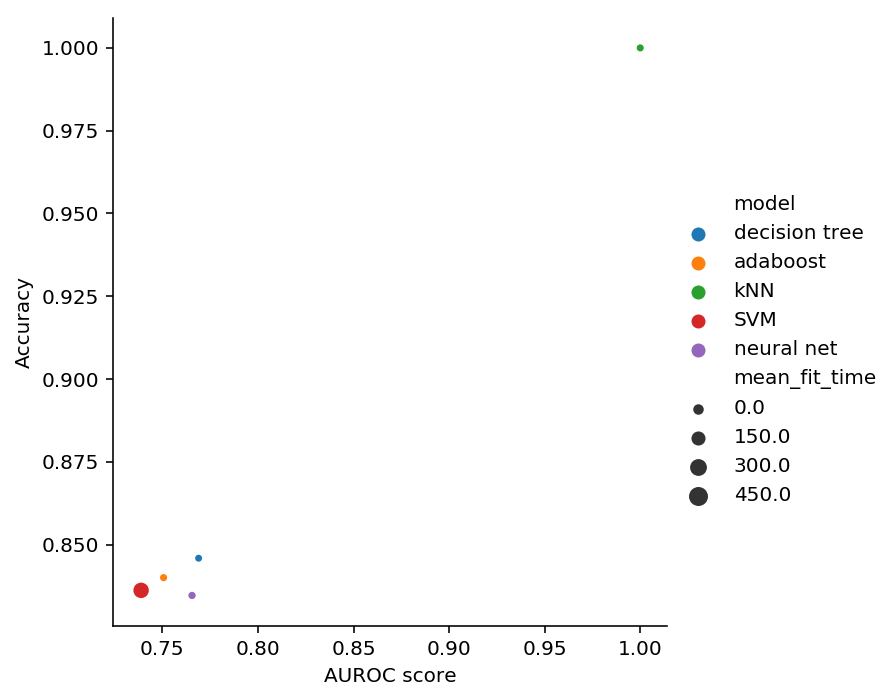

In [303]:
sns.relplot(x='AUROC score',
            y='Accuracy', 
            hue='model',
            size='mean_fit_time',data=x_model_res_a)

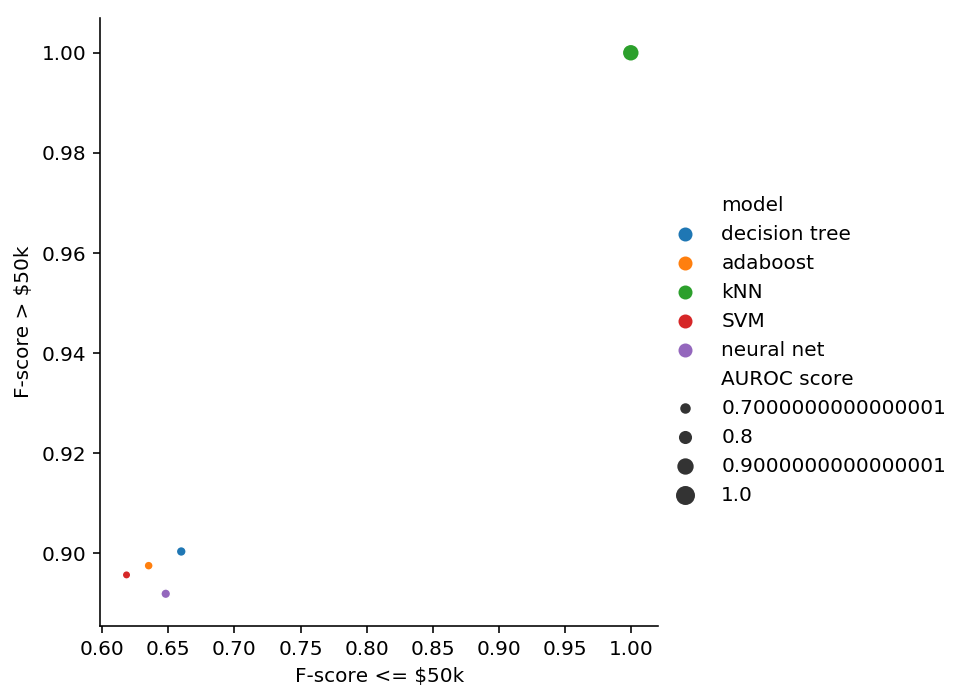

In [304]:
sns.relplot(x='F-score <= $50k',
            y='F-score > $50k', 
            hue='model',
            size='AUROC score',
            data=x_model_res_a)

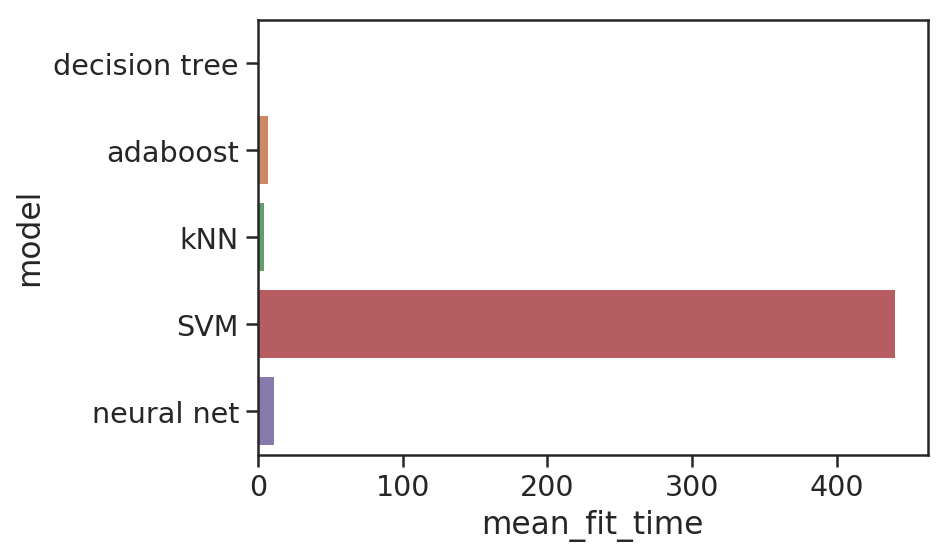

In [411]:
sns.barplot(x='mean_fit_time',y='model',data=x_model_res_a)